# Practica No 2: SimPy SED 


## Nombre:

###       Fernando Sanchez

## Enunciado:

    •	Considerar 3 tipos de vehículos con 3 diferentes tiempos de lavado:
        •	Bus: 20 minutos
        •	Automóvil: 7 minutos
        •	Furgoneta: 12 minutos
    •	Considere que a partir de la entrada del vehículo para ser lavado, deberán tomarse en cuenta los
         siguientes tiempos correspondientes al proceso de traslado desde la recepción a la máquina de lavado:
        •	Bus: 4 minutos
        •	Automóvil: 1 minuto
        •	Furgoneta: 2 minutos
    •	Realice una gráfica de la simulación con 3 máquinas de lavado

In [1]:
# Importar librerias necesarias
import simpy
import random
import matplotlib.pyplot as plt

In [20]:
# Maximo de vehiculos que puede recibir el negocio
MAX_VEHICULOS = 57 
# Total de maquinas de lavado con que cuenta el negocio
NUM_MAQUINAS = 3
#Tiempo de traslado de vehiculos
INTERVALO_TRASLADO= [4,1,2]
# Tiempo que tarda en lavarse un vehiculo (minutos)
#Bus: 20min, Automóvil: 7min, Furgoneta: 12min
TIEMPO_LAVADO =[20,7,12] #7 
# Intervalo de tiempo en que llegan vehiculos (minutos= Bus 4 minutos, Automóvil 1 minuto, Furgoneta 2 minutos) 
INTERVALO_LLEGADA = 10
# Tiempo de simulación
TIEMPO_SIMULACION = 100

tiempo= {}

class Lavanderia(object):
    
    def __init__(self, environment, num_maquinas,tiempo_bus,tiempo_automovil,
                 tiempo_furgoneta,traslado_bus,traslado_automovil,traslado_furgoneta):
        # Guardamos como variable el entorno de ejecucion
        self.env=environment
        # Creamos el recurso que representa las maquinas
        self.maquinas = simpy.Resource(environment, num_maquinas)
        # Variable para el tiempo de lavado
        self.tiempo_bus = tiempo_bus
        self.tiempo_automovil = tiempo_automovil
        self.tiempo_furgoneta = tiempo_furgoneta
        self.traslado_bus = traslado_bus
        self.traslado_automovil = traslado_automovil
        self.traslado_furgoneta = traslado_furgoneta
        
    def lavar_vehiculo(self, vehiculo):
        automotor=vehiculo.split('-')
        if(automotor[0] == 'Bus'):
            yield self.env.timeout(INTERVALO_TRASLADO[0])
        if(automotor[0] == 'Automóvil'):
            yield self.env.timeout(INTERVALO_TRASLADO[1])
        if(automotor[0] == 'Furgoneta'):
            yield self.env.timeout(INTERVALO_TRASLADO[2])
        #Solo agregamos al diccionario al momento que termina de lavar el vehiculo.
        k=automotor[0]
        if k in tiempo:
            tiempo[k]=tiempo[k]+1
        else:
            tiempo[k]=1
            
        # Simulamos que se ha limpiado parte (%) de la suciedad del vehiculo
        # Para el % generamos un entero entre 30 y 90
        print('Removido  {%d%%} suciedad vehiculo => %s ' %(random.randint(30,90), vehiculo))
        
    def trasladar_vehiculo(self, vehiculo):
        automotor=vehiculo.split('-')
        if(automotor[0] == 'Bus'):
            yield self.env.timeout(INTERVALO_TRASLADO[0])
        if(automotor[0] == 'Automóvil'):
            yield self.env.timeout(INTERVALO_TRASLADO[1])
        if(automotor[0] == 'Furgoneta'):
            yield self.env.timeout(INTERVALO_TRASLADO[2])
       
    
def llegada_vehiculo(env, nombre, lavanderia):
    # Usamos el reloj de la simulacion (env.now()) para indicar a la
    # hora que llega el vehiculo con el nombre pasado como parametro
    print('Llega vehiculo: %s a la hora %.2f.' % (nombre, env.now))
    
    # Especificamos que vamos a usar un recurso (Resource) que representa
    # la maquina de lavado
    with lavanderia.maquinas.request() as maquina:
        # Ocupamos la maquina de lavado
        yield maquina
        #Indicamos que el vehiculo se esta trasladando para ser lavado
        print('Se traslada vehiculo: %s a la hora %.2f.' % (nombre,env.now))
        #Procesamos el traslado del vehiculo
        yield env.process(lavanderia.trasladar_vehiculo(nombre))
        # Indicamos que vehiculo entra a la lavanderia
        print('Entra vehiculo a lavarse: %s a la hora %.2f.' % (nombre, env.now))
        # Procesamos la operacion de lavado
        yield env.process(lavanderia.lavar_vehiculo(nombre))
        # Una vez que termina la llamada con 'yield', se indica que se ha lavado el vehiculo
        print('Vehiculo [%s] lavado a las %.2f.' % (nombre, env.now))  
        
def ejecutar_simulacion(env, num_maquinas, tiempo_bus,tiempo_automovil,tiempo_furgoneta,traslado_bus,
                        traslado_automovil,traslado_furgoneta, intervalo):
    lavanderia = Lavanderia(env, num_maquinas, tiempo_bus,tiempo_automovil,tiempo_furgoneta,traslado_bus,
                          traslado_automovil,traslado_furgoneta)
    # Creamos 5 llegadas de vehiculos iniciales
    for i in range(2):
        env.process(llegada_vehiculo(env, 'Bus-%d'%(i+1),lavanderia))
        env.process(llegada_vehiculo(env, 'Automóvil-%d'%(i+1),lavanderia))
        env.process(llegada_vehiculo(env, 'Furgoneta-%d'%(i+1),lavanderia))
        
    # Ejecutamos la simulacion
    while True:
        yield env.timeout(random.randint(intervalo-3, intervalo+3))
        i+=1
        # Mientras se lavan los vehiculos generamos mas vehiculos
        rnd = random.randint(1,101)
        # Probalidad de Bus 20 minutos, Automóvil 7 minutos, Furgoneta 12 minutos 
        # # Bus 51%, Automóvil 18%, Furgoneta 31%
        if rnd <= 18: 
            env.process(llegada_vehiculo(env,'Automóvil-%d'%(i+1),lavanderia))
        elif rnd <= 31:
            env.process(llegada_vehiculo(env,'Furgoneta-%d'%(i+1),lavanderia))
        else:
            env.process(llegada_vehiculo(env,'Bus-%d'%(i+1),lavanderia))

print('Lavanderia UPS')

# Inicializamos la semilla aleatoria
random.seed(77)

# Creamos el entorno de simulacion
env=simpy.Environment()
env.process(ejecutar_simulacion(env, NUM_MAQUINAS, TIEMPO_LAVADO[0],TIEMPO_LAVADO[1],TIEMPO_LAVADO[2]\
                                ,TRASLADO[0],TRASLADO[1],TRASLADO[2], INTERVALO_LLEGADA))

# Ejecutamos el proceso durante el tiempo de simulacion
env.run(until = TIEMPO_SIMULACION)

print("Diccionario tiempo :")
print(tiempo)

Lavanderia UPS
Llega vehiculo: Bus-1 a la hora 0.00.
Llega vehiculo: Automóvil-1 a la hora 0.00.
Llega vehiculo: Furgoneta-1 a la hora 0.00.
Llega vehiculo: Bus-2 a la hora 0.00.
Llega vehiculo: Automóvil-2 a la hora 0.00.
Llega vehiculo: Furgoneta-2 a la hora 0.00.
Se traslada vehiculo: Bus-1 a la hora 0.00.
Se traslada vehiculo: Automóvil-1 a la hora 0.00.
Se traslada vehiculo: Furgoneta-1 a la hora 0.00.
Entra vehiculo a lavarse: Automóvil-1 a la hora 1.00.
Removido  {46%} suciedad vehiculo => Automóvil-1 
Entra vehiculo a lavarse: Furgoneta-1 a la hora 2.00.
Vehiculo [Automóvil-1] lavado a las 2.00.
Se traslada vehiculo: Bus-2 a la hora 2.00.
Removido  {50%} suciedad vehiculo => Furgoneta-1 
Entra vehiculo a lavarse: Bus-1 a la hora 4.00.
Vehiculo [Furgoneta-1] lavado a las 4.00.
Se traslada vehiculo: Automóvil-2 a la hora 4.00.
Entra vehiculo a lavarse: Automóvil-2 a la hora 5.00.
Removido  {42%} suciedad vehiculo => Automóvil-2 
Entra vehiculo a lavarse: Bus-2 a la hora 6.00.
Veh

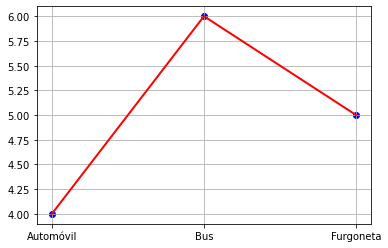

In [21]:
# Generamos la grafica
datos=sorted(tiempo.items())
x, y =zip(*datos)
plt.plot(x,y,linewidth=2,color='red')
plt.scatter(x,y,color='blue')
plt.grid(True)
plt.show()

In [22]:
# Maximo de vehiculos que puede recibir el negocio
MAX_VEHICULOS = 57 
# Total de maquinas de lavado con que cuenta el negocio
NUM_MAQUINAS = 4
#Tiempo de traslado de vehiculos
INTERVALO_TRASLADO= [4,1,2]
# Tiempo que tarda en lavarse un vehiculo (minutos)
#Bus: 20min, Automóvil: 7min, Furgoneta: 12min
TIEMPO_LAVADO =[20,7,12] #7 
# Intervalo de tiempo en que llegan vehiculos (minutos= Bus 4 minutos, Automóvil 1 minuto, Furgoneta 2 minutos) 
INTERVALO_LLEGADA = 10
# Tiempo de simulación
TIEMPO_SIMULACION = 100

tiempo1= {}

class Lavanderia(object):
    
    def __init__(self, environment, num_maquinas,tiempo_bus,tiempo_automovil,
                 tiempo_furgoneta,traslado_bus,traslado_automovil,traslado_furgoneta):
        # Guardamos como variable el entorno de ejecucion
        self.env=environment
        # Creamos el recurso que representa las maquinas
        self.maquinas = simpy.Resource(environment, num_maquinas)
        # Variable para el tiempo de lavado
        self.tiempo_bus = tiempo_bus
        self.tiempo_automovil = tiempo_automovil
        self.tiempo_furgoneta = tiempo_furgoneta
        self.traslado_bus = traslado_bus
        self.traslado_automovil = traslado_automovil
        self.traslado_furgoneta = traslado_furgoneta
        
    def lavar_vehiculo(self, vehiculo):
        automotor=vehiculo.split('-')
        if(automotor[0] == 'Bus'):
            yield self.env.timeout(INTERVALO_TRASLADO[0])
        if(automotor[0] == 'Automóvil'):
            yield self.env.timeout(INTERVALO_TRASLADO[1])
        if(automotor[0] == 'Furgoneta'):
            yield self.env.timeout(INTERVALO_TRASLADO[2])
        #Solo agregamos al diccionario al momento que termina de lavar el vehiculo.
        k=automotor[0]
        if k in tiempo1:
            tiempo1[k]=tiempo1[k]+1
        else:
            tiempo1[k]=1
            
        # Simulamos que se ha limpiado parte (%) de la suciedad del vehiculo
        # Para el % generamos un entero entre 30 y 90
        print('Removido  {%d%%} suciedad vehiculo => %s ' %(random.randint(30,90), vehiculo))
        
    def trasladar_vehiculo(self, vehiculo):
        automotor=vehiculo.split('-')
        if(automotor[0] == 'Bus'):
            yield self.env.timeout(INTERVALO_TRASLADO[0])
        if(automotor[0] == 'Automóvil'):
            yield self.env.timeout(INTERVALO_TRASLADO[1])
        if(automotor[0] == 'Furgoneta'):
            yield self.env.timeout(INTERVALO_TRASLADO[2])
       
    
def llegada_vehiculo(env, nombre, lavanderia):
    # Usamos el reloj de la simulacion (env.now()) para indicar a la
    # hora que llega el vehiculo con el nombre pasado como parametro
    print('Llega vehiculo: %s a la hora %.2f.' % (nombre, env.now))
    
    # Especificamos que vamos a usar un recurso (Resource) que representa
    # la maquina de lavado
    with lavanderia.maquinas.request() as maquina:
        # Ocupamos la maquina de lavado
        yield maquina
        #Indicamos que el vehiculo se esta trasladando para ser lavado
        print('Se traslada vehiculo: %s a la hora %.2f.' % (nombre,env.now))
        #Procesamos el traslado del vehiculo
        yield env.process(lavanderia.trasladar_vehiculo(nombre))
        # Indicamos que vehiculo entra a la lavanderia
        print('Entra vehiculo a lavarse: %s a la hora %.2f.' % (nombre, env.now))
        # Procesamos la operacion de lavado
        yield env.process(lavanderia.lavar_vehiculo(nombre))
        # Una vez que termina la llamada con 'yield', se indica que se ha lavado el vehiculo
        print('Vehiculo [%s] lavado a las %.2f.' % (nombre, env.now))  
        
def ejecutar_simulacion(env, num_maquinas, tiempo_bus,tiempo_automovil,tiempo_furgoneta,traslado_bus,
                        traslado_automovil,traslado_furgoneta, intervalo):
    lavanderia = Lavanderia(env, num_maquinas, tiempo_bus,tiempo_automovil,tiempo_furgoneta,traslado_bus,
                          traslado_automovil,traslado_furgoneta)
    # Creamos 5 llegadas de vehiculos iniciales
    for i in range(2):
        env.process(llegada_vehiculo(env, 'Bus-%d'%(i+1),lavanderia))
        env.process(llegada_vehiculo(env, 'Automóvil-%d'%(i+1),lavanderia))
        env.process(llegada_vehiculo(env, 'Furgoneta-%d'%(i+1),lavanderia))
        
    # Ejecutamos la simulacion
    while True:
        yield env.timeout(random.randint(intervalo-3, intervalo+3))
        i+=1
        # Mientras se lavan los vehiculos generamos mas vehiculos
        rnd = random.randint(1,101)
        # Probalidad de Bus 20 minutos, Automóvil 7 minutos, Furgoneta 12 minutos 
        # # Bus 51%, Automóvil 18%, Furgoneta 31%
        if rnd <= 18: 
            env.process(llegada_vehiculo(env,'Automóvil-%d'%(i+1),lavanderia))
        elif rnd <= 31:
            env.process(llegada_vehiculo(env,'Furgoneta-%d'%(i+1),lavanderia))
        else:
            env.process(llegada_vehiculo(env,'Bus-%d'%(i+1),lavanderia))

print('Lavanderia UPS')

# Inicializamos la semilla aleatoria
random.seed(77)

# Creamos el entorno de simulacion
env=simpy.Environment()
env.process(ejecutar_simulacion(env, NUM_MAQUINAS, TIEMPO_LAVADO[0],TIEMPO_LAVADO[1],TIEMPO_LAVADO[2]\
                                ,TRASLADO[0],TRASLADO[1],TRASLADO[2], INTERVALO_LLEGADA))

# Ejecutamos el proceso durante el tiempo de simulacion
env.run(until = TIEMPO_SIMULACION)

print("Diccionario tiempo 4 maquinas:")
print(tiempo1)

Lavanderia UPS
Llega vehiculo: Bus-1 a la hora 0.00.
Llega vehiculo: Automóvil-1 a la hora 0.00.
Llega vehiculo: Furgoneta-1 a la hora 0.00.
Llega vehiculo: Bus-2 a la hora 0.00.
Llega vehiculo: Automóvil-2 a la hora 0.00.
Llega vehiculo: Furgoneta-2 a la hora 0.00.
Se traslada vehiculo: Bus-1 a la hora 0.00.
Se traslada vehiculo: Automóvil-1 a la hora 0.00.
Se traslada vehiculo: Furgoneta-1 a la hora 0.00.
Se traslada vehiculo: Bus-2 a la hora 0.00.
Entra vehiculo a lavarse: Automóvil-1 a la hora 1.00.
Removido  {46%} suciedad vehiculo => Automóvil-1 
Entra vehiculo a lavarse: Furgoneta-1 a la hora 2.00.
Vehiculo [Automóvil-1] lavado a las 2.00.
Se traslada vehiculo: Automóvil-2 a la hora 2.00.
Entra vehiculo a lavarse: Automóvil-2 a la hora 3.00.
Removido  {50%} suciedad vehiculo => Furgoneta-1 
Removido  {42%} suciedad vehiculo => Automóvil-2 
Entra vehiculo a lavarse: Bus-1 a la hora 4.00.
Entra vehiculo a lavarse: Bus-2 a la hora 4.00.
Vehiculo [Furgoneta-1] lavado a las 4.00.
Veh

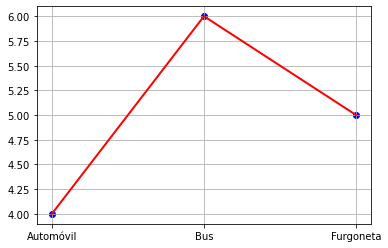

In [24]:
# Generamos la grafica
datos1=sorted(tiempo1.items())
x, y =zip(*datos1)
plt.plot(x,y,linewidth=2,color='red')
plt.scatter(x,y,color='blue')
plt.grid(True)
plt.show()

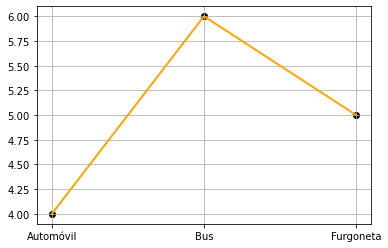

In [27]:
# Generamos la grafica
datos=sorted(tiempo.items())
x, y =zip(*datos)
plt.plot(x,y,linewidth=2,color='orange')
plt.scatter(x,y,color='black')
plt.grid(True)
plt.show()